In [2]:
import sys
sys.path.append('../')

from util.benchmarking import *

from quantum.hamiltonians import heisenberg,long_range_tfim,transverse_ising,cluster,Madjumdar_Gosh,long_range_XY_model
from quantum.util import flatten_mpo,flatten_mps,measure_magnetizations
from quantum.basis_enrichment import expand, MPS_krylov
from quantum.dmrg import dmrg2
from quantum.tdvp import tdvp_implicit

from tensornetwork.contraction import random_contraction_inc
from tensornetwork.stopping import Cutoff,FixedDimension
from tensornetwork.linalg import truncated_svd
from tensornetwork.MPO import MPO
from tensornetwork.MPS import MPS

import time
import pandas as pd
import numpy as np 
import scipy 
from tqdm import tqdm 
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

Using C++ implementation for incQR


### Takes 13 minutes for setup

---

In [144]:
a = -.5
chi = 50
n = 100
mpo,mps,baseline = generate_baseline(n,chi,a,dtype=np.complex128)

Generating baseline contraction...


In [197]:
print(mpo.max_bond_dim())

50


In [189]:
def cutoff_synth_tensor_experiment(mpo,mps,baseline,cutoffs,names,a=-.5,b=1,highres=False,return_data=False,
                                   fit_sweeps=1,sketch_dim=2,sketch_increment=3,no_plot=True):
    # baseline.canonize()
    # print(baseline.norm())
    
    times = {name: [] for name in names}
    accs = {name: [] for name in names}
    bond_dims = {name: [] for name in names}

    column_names = ['Cutoff Value'] + [f'{name} {metric}' for name in names for metric in ['Time', 'Accuracy']]  
    results_df = pd.DataFrame(columns=column_names)
    display(results_df)


    for cutoff in cutoffs:
        for name in names:
            print(name)
            start = time.time()
            if name == 'naive':
                result = mps_mpo_blas(mps, mpo, stop=Cutoff(cutoff),round_type = "dass_blas")
            elif name == 'random':
                result = random_contraction_inc(mpo, mps, stop=Cutoff(cutoff), accuracychecks=False, 
                                              finalround=Cutoff(cutoff),sketchincrement=sketch_increment,sketchdim=sketch_dim)
            elif name == 'random+oversample':
                    result = random_contraction_inc(mpo, mps, stop=Cutoff(cutoff/10), accuracychecks=False, 
                                                    finalround=Cutoff(cutoff), sketchincrement=sketch_increment, sketchdim=sketch_dim)
            elif name == 'density':
                result = density_matrix(mpo, mps,stop=Cutoff(cutoff))
            elif name == 'zipup':
                result = zipup(mpo, mps, stop=Cutoff(cutoff),finalround=False,conditioning=True)
            elif name == 'rzipup':
                result = zipup_randomsvd(mpo, mps, stop=Cutoff(cutoff),finalround=False,conditioning=True)
            elif name == 'fit':
                result = fit(mpo, mps, max_sweeps=fit_sweeps,stop=Cutoff(cutoff))
            else:
                print("Invalid algorithm choice for ", name, " review your inputted algorithm names")
                return
            
            times[name].append(time.time() - start)
            accs[name].append((baseline - result).norm() / baseline.norm())
            bond_dims[name].append(result.max_bond_dim())
            
        # Data Frame population
        new_row_data = {'Cutoff Value': cutoff}
        for name in names:
            new_row_data[f'{name} Time'] = times[name][-1]
            new_row_data[f'{name} Accuracy'] = accs[name][-1]
        new_row_df = pd.DataFrame([new_row_data])
        results_df = pd.concat([results_df, new_row_df], ignore_index=True)
        clear_output(wait=True)
        display(results_df)
    if no_plot:
        pass
    elif highres:
         # High resolution separate plots
        plt.figure( dpi=400)
        plot_times_reversed(names, cutoffs, times)
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        plt.figure( dpi=400)
        plot_accuracy_reversed(names, cutoffs, accs)
        plt.tight_layout()
        plt.grid(True)

        plt.show()
    else:
        # Standard multi-plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 
        plot_times_reversed(names, cutoffs, times, ax=axs[0])
        plot_accuracy_reversed(names, cutoffs, accs, ax=axs[1])
    if return_data:
        return times,accs,bond_dims

In [190]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

def benchmark(N, mpo, mps, baseline, cutoff_values, names, a, fit_sweeps=2):
    # Initialize containers for storing results
    results = []

    # Run the benchmark for each name individually
    for name in names:
        times_results = []
        acc_results = []
        bond_dims_results = []

        # Run the experiment N times for the given name
        for _ in range(N):
            times, acc, bond_dims = cutoff_synth_tensor_experiment(
                mpo, mps, baseline, cutoff_values, [name], a, highres=True, 
                return_data=True, fit_sweeps=fit_sweeps
            )
            times_results.append(times[name])
            acc_results.append(acc[name])
            bond_dims_results.append(bond_dims[name])

        # Compute mean and std for this name across all runs
        mean_times = np.mean(times_results, axis=0)
        std_times = np.std(times_results, axis=0)
        mean_acc = np.mean(acc_results, axis=0)
        std_acc = np.std(acc_results, axis=0)
        mean_bond_dims = np.mean(bond_dims_results, axis=0)
        std_bond_dims = np.std(bond_dims_results, axis=0)

        # Store the results in a structured format
        for i, cutoff in enumerate(cutoff_values):
            results.append({
                'name': name,
                'cutoff_value': cutoff,
                'mean_time': mean_times[i],
                'std_time': std_times[i],
                'mean_accuracy': mean_acc[i],
                'std_accuracy': std_acc[i],
                'mean_bond_dim': mean_bond_dims[i],
                'std_bond_dim': std_bond_dims[i]
            })

    # Save results to a timestamped CSV file
    save_results_to_csv(results)

def save_results_to_csv(results):
    """Save benchmark results to a timestamped CSV file."""
    # Ensure the directory exists
    os.makedirs('Figure4_data', exist_ok=True)

    # Create a timestamped filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = f'Figure4_data/benchmark_results_{timestamp}.csv'

    # Convert results to a DataFrame and save to CSV
    df = pd.DataFrame(results)
    df.to_csv(csv_path, index=False)

# # Example usage
N = 5 
cutoff_values = np.array([10**-i for i in range(2, 15)]) 
# names = ['naive', 'zipup', 'fit', 'density', 'random', 'random+oversample']
names = ['random']#, 'zipup', 'fit', 'density', 'random', 'random+oversample']
benchmark(N, mpo, mps, baseline, cutoff_values, names, a)

,Cutoff Value,random Time,random Accuracy
0,1.00e-02,2.27e-01,2.19e-02
1,1.00e-03,2.66e-01,6.99e-03
2,1.00e-04,2.86e-01,5.62e-04
3,1.00e-05,3.17e-01,6.33e-05
4,1.00e-06,4.55e-01,8.78e-06
5,1.00e-07,6.50e-01,1.09e-06
6,1.00e-08,9.30e-01,1.44e-07
7,1.00e-09,1.39e+00,1.13e-08
8,1.00e-10,1.83e+00,9.76e-10
9,1.00e-11,2.23e+00,1.33e-10


In [207]:
print(N)

5


In [206]:
cutoff_values = np.array([10**-i for i in range(2, 15)]) 

names = ['zipup']#, 'zipup', 'fit', 'density', 'random', 'random+oversample']
benchmark(N, mpo, mps, baseline, cutoff_values, names, a)

,Cutoff Value,zipup Time,zipup Accuracy
0,1.00e-02,5.21e-02,2.04e-02
1,1.00e-03,5.15e-02,2.83e-03
2,1.00e-04,1.30e-01,2.62e-04
3,1.00e-05,2.74e-01,2.64e-05
4,1.00e-06,5.40e-01,2.86e-06
5,1.00e-07,1.00e+00,2.67e-07
6,1.00e-08,1.89e+00,2.92e-08
7,1.00e-09,3.31e+00,3.61e-09
8,1.00e-10,4.70e+00,3.05e-10
9,1.00e-11,6.98e+00,3.18e-11


In [199]:
names = ['density']#, 'zipup', 'fit', 'density', 'random', 'random+oversample']
benchmark(N, mpo, mps, baseline, cutoff_values, names, a)

,Cutoff Value,density Time,density Accuracy
0,1.00e-14,1.30e+02,2.78e-13
1,1.00e-13,1.29e+02,1.22e-12
2,1.00e-12,1.29e+02,1.39e-11
3,1.00e-11,1.28e+02,1.66e-10
4,1.00e-10,1.28e+02,1.69e-09
5,1.00e-09,1.27e+02,1.46e-08
6,1.00e-08,1.28e+02,1.28e-07
7,1.00e-07,1.27e+02,7.84e-07
8,1.00e-06,1.27e+02,7.30e-06
9,1.00e-05,1.27e+02,5.03e-05


In [ ]:
def benchmark(N, mpo, mps, baseline, cutoff_values, names, a, fit_sweeps=2):
    # Initialize containers for storing results across multiple runs
    times_results = {name: [] for name in names}
    acc_results = {name: [] for name in names}
    bond_dims_results = {name: [] for name in names}

    # Run the experiment N times
    for _ in range(N):
        times, acc, bond_dims = cutoff_synth_tensor_experiment(
            mpo, mps, baseline, cutoff_values, names, a, highres=True, return_data=True, fit_sweeps=fit_sweeps
        )

        # Collect the results for this run
        for name in names:
            times_results[name].append(times[name])
            acc_results[name].append(acc[name])
            bond_dims_results[name].append(bond_dims[name])

    # Compute mean and std for each metric across all runs
    mean_times = {name: np.mean(times_results[name], axis=0) for name in names}
    std_times = {name: np.std(times_results[name], axis=0) for name in names}
    mean_acc = {name: np.mean(acc_results[name], axis=0) for name in names}
    std_acc = {name: np.std(acc_results[name], axis=0) for name in names}
    mean_bond_dims = {name: np.mean(bond_dims_results[name], axis=0) for name in names}
    std_bond_dims = {name: np.std(bond_dims_results[name], axis=0) for name in names}

    return mean_times, std_times, mean_acc, std_acc, mean_bond_dims, std_bond_dims

# Example usage
N = 5 
cutoff_values = np.array([10**-i for i in range(2, 15)]) 
names = ['naive',  'zipup', 'fit', 'density', 'random','random+oversample']  
mean_times, std_times, mean_acc, std_acc, mean_bond_dims, std_bond_dims = benchmark(
    N, mpo, mps, baseline, cutoff_values, names, a
)


In [5]:
# Global settings for consistency
global_font_size = 18
global_marker_size = 8
global_line_width = 2

# Define plot styles globally for reuse
PLOT_STYLES = {
    'naive': ('Set1', 0, 'o', 'Contract-Then-Compress', '-'),   
    'random': ('Set1', 1, 's', 'Randomized', '-'),  
    'zipup': ('Set1', 2, 'D', 'Zip-up', '-'),       
    'density': ('Set1', 3, '^', 'Density Matrix', '-'), 
    'fit': ('Set1', 4, 'v', 'Fitting', '-'),        
    'random+oversample': ('c', None, 'v', 'Randomized+Oversample', '--'),
    'rzipup': ('Set1', 5, 'D', 'Zip-up', '-'),       
}

def plot_graph(test_names, cutoffs, data, std_data, y_label, title, ax, y_scale='log',naive_marker_flag=True):
    """Helper function to plot a single graph with conditional formatting and fill_between for std."""
    palette = sns.color_palette("Set1", 6)

    for name in test_names:
        if name in PLOT_STYLES and name in data:
            palette_name, color_idx, marker, label, linestyle = PLOT_STYLES[name]
            color = sns.color_palette(palette_name, 6)[color_idx] if color_idx is not None else palette_name

            # Extract the mean and std data for fill_between
            mean_values = data[name]
            std_values = std_data[name] if std_data and name in std_data else np.zeros_like(mean_values)

            if name == 'naive':
                # Plot 'naive' with custom styling
                if naive_marker_flag:
                    ax.plot(
                        cutoffs, mean_values, color=color, marker=marker, label=label,
                        markersize=16, linewidth=global_line_width, linestyle=linestyle,
                        markerfacecolor='none', markeredgewidth=1, alpha=1
                    )
                else:
                    ax.plot(
                        cutoffs, mean_values, color=color, marker=marker, label=label,
                        markersize=8, linewidth=global_line_width, linestyle=linestyle,
                        markerfacecolor='none', markeredgewidth=1, alpha=1
                    )
            else:
                # Plot other lines with default settings
                ax.plot(
                    cutoffs, mean_values, color=color, marker=marker, label=label,
                    markersize=global_marker_size, linewidth=global_line_width, linestyle=linestyle
                )

            # Add fill_between for std
            ax.fill_between(
                cutoffs,
                mean_values - std_values, mean_values + std_values,
                color=color, alpha=0.2
            )

    ax.set_yscale(y_scale)
    ax.set_xscale('log')
    ax.set_xlabel('Tolerance', fontsize=global_font_size)
    ax.set_ylabel(y_label, fontsize=global_font_size)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=global_font_size - 2)

def combined_plot(test_names, cutoff_values, mean_times, std_times, 
                  mean_acc, std_acc, mean_bond_dims, std_bond_dims):
    """Function to create a combined plot with three subplots and a shared top legend."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

    # Adjust layout for tighter spacing
    plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.85)

    # Plot each graph on the respective axis
    plot_graph(test_names, cutoff_values, mean_times, std_times, 'Time (s)', None, axes[0],naive_marker_flag=False)
    plot_graph(test_names, cutoff_values, mean_acc, std_acc, 'Relative Error', None, axes[1])
    plot_graph(test_names, cutoff_values, mean_bond_dims, std_bond_dims, 'Bond Dimension', None, axes[2],y_scale="log",)

    # Collect legend handles and labels from one of the axes
    handles, labels = axes[0].get_legend_handles_labels()

    # Create a shared legend at the top of the figure
    fig.legend(
        handles, labels, loc='upper center', fontsize=global_font_size - 1, ncol=3, 
        bbox_to_anchor=(0.5, 1.2)
    )

    # Show the plot
    plt.show()

/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_17553/4067550893.py:73: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.85)


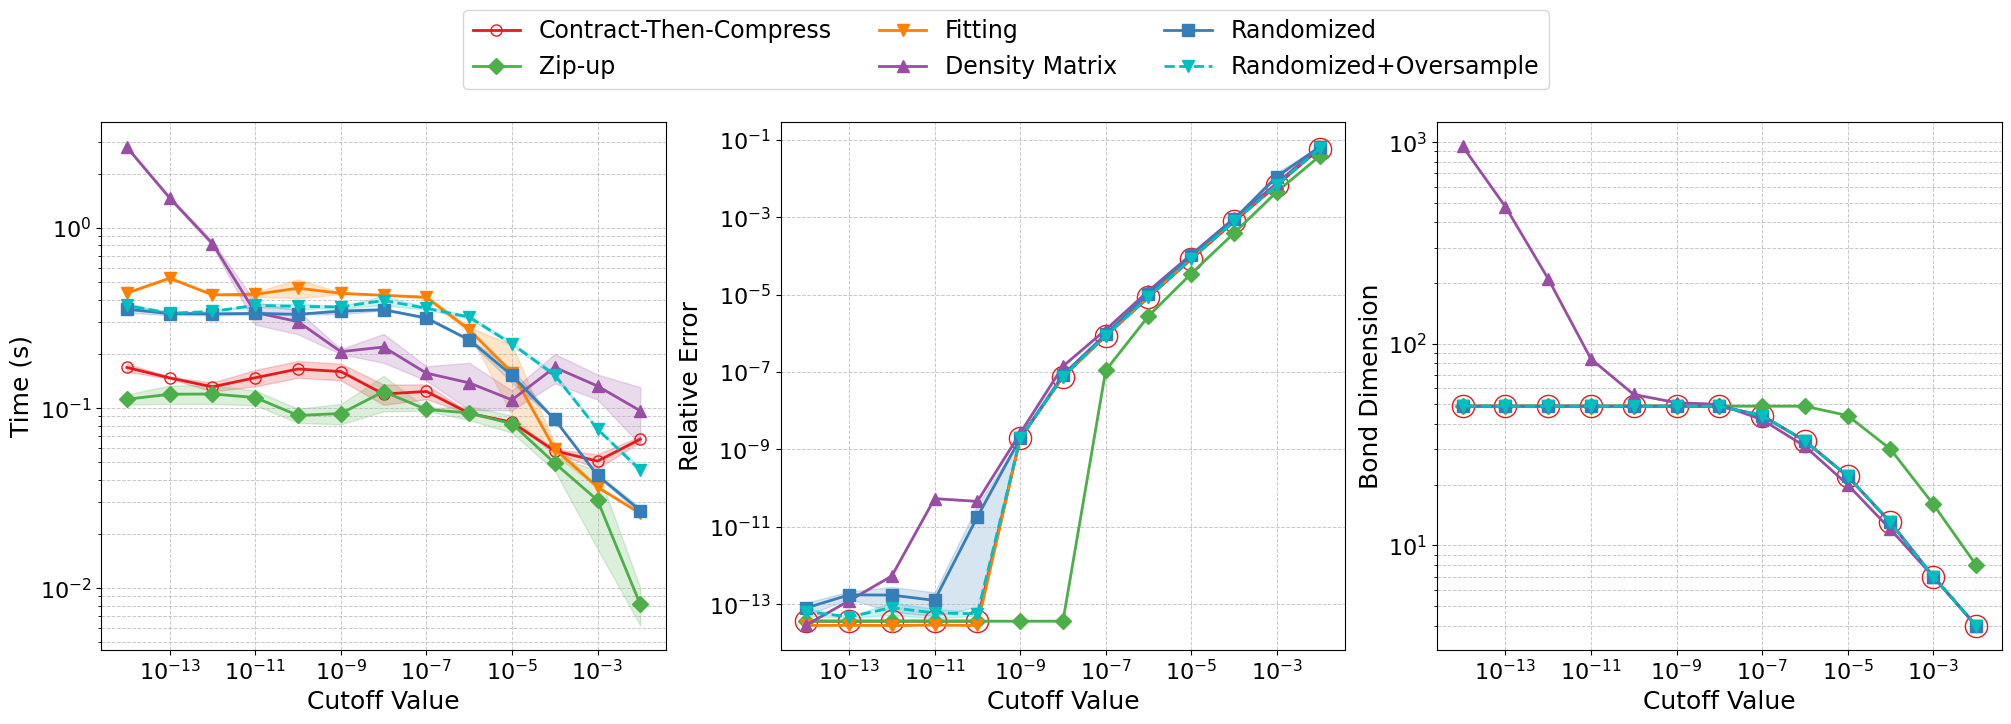

In [123]:
combined_plot(names, cutoff_values, mean_times,std_times, mean_acc,std_acc, mean_bond_dims,std_bond_dims)

/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_84767/2340837202.py:73: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.85)


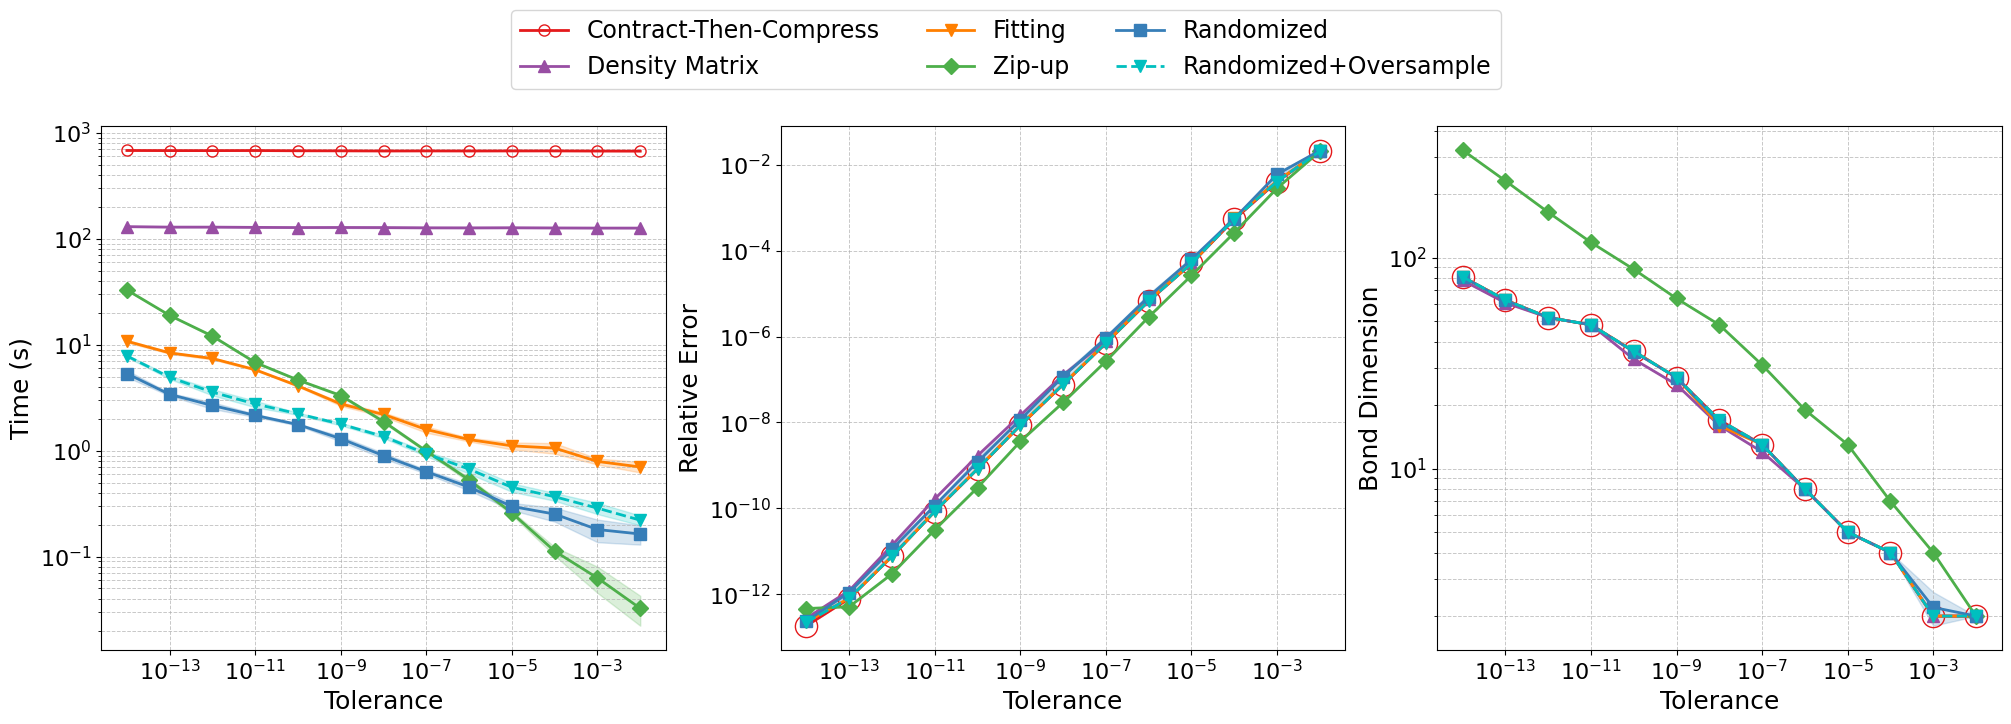

In [6]:
import pandas as pd
import numpy as np

def prepare_data_for_plotting(file_path):
    """
    Reads the CSV file containing benchmark data and prepares it for plotting.

    Parameters:
    - file_path (str): Path to the CSV file containing the benchmark data.

    Returns:
    - test_names (list): List of unique test names.
    - cutoff_values (list): Sorted list of unique cutoff values.
    - mean_times (dict): Dictionary of mean times for each test name.
    - std_times (dict): Dictionary of standard deviations of times for each test name.
    - mean_acc (dict): Dictionary of mean accuracies for each test name.
    - std_acc (dict): Dictionary of standard deviations of accuracies for each test name.
    - mean_bond_dims (dict): Dictionary of mean bond dimensions for each test name.
    - std_bond_dims (dict): Dictionary of standard deviations of bond dimensions for each test name.
    """
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Get the list of unique test names
    test_names = df['name'].unique().tolist()
    
    # Get the list of unique cutoff values, sorted in increasing order
    cutoff_values = sorted(df['cutoff_value'].unique())
    
    # Initialize dictionaries to hold data for each test_name
    mean_times = {}
    std_times = {}
    mean_acc = {}
    std_acc = {}
    mean_bond_dims = {}
    std_bond_dims = {}
    
    # For each test name, extract the data and organize it
    for name in test_names:
        # Filter the DataFrame for the current name
        df_name = df[df['name'] == name]
        
        # Sort the DataFrame by cutoff_value to ensure consistent ordering
        df_name = df_name.sort_values('cutoff_value')
        
        # Extract the data arrays
        mean_times[name] = df_name['mean_time'].values
        std_times[name] = df_name['std_time'].values
        mean_acc[name] = df_name['mean_accuracy'].values
        std_acc[name] = df_name['std_accuracy'].values
        mean_bond_dims[name] = df_name['mean_bond_dim'].values
        std_bond_dims[name] = df_name['std_bond_dim'].values
    
    return (test_names, cutoff_values, mean_times, std_times, 
            mean_acc, std_acc, mean_bond_dims, std_bond_dims)

# Example usage:
file_path = "Figure4_data/final_data.csv"  # Update this path if needed
(test_names, cutoff_values, mean_times, std_times, 
 mean_acc, std_acc, mean_bond_dims, std_bond_dims) = prepare_data_for_plotting(file_path)

# Now you can pass these to your plotting functions
combined_plot(test_names, cutoff_values, mean_times, std_times, 
              mean_acc, std_acc, mean_bond_dims, std_bond_dims)

In [213]:
mean_times

{'naive': array([682.94803638, 681.18594942, 680.90151243, 682.28158784,
        678.68089571, 677.69282203, 675.80008826, 676.65869741,
        675.90219798, 676.55081611, 676.85279365, 674.94681101,
        673.7131072 ]),
 'density': array([130.44714179, 129.06419406, 129.03315582, 128.34003563,
        127.85540619, 128.06332211, 127.82301335, 127.16707907,
        127.00532303, 127.31997538, 126.75115914, 126.41256399,
        126.36370621]),
 'fit': array([10.80263681,  8.38395567,  7.42175193,  5.81230097,  4.09100285,
         2.75953965,  2.19708672,  1.58478136,  1.27249346,  1.11141915,
         1.05735984,  0.79155216,  0.70167093]),
 'zipup': array([3.28958187e+01, 1.89255174e+01, 1.20725327e+01, 6.80242052e+00,
        4.64635863e+00, 3.31788721e+00, 1.88279452e+00, 9.90677929e-01,
        5.30014992e-01, 2.57949352e-01, 1.12559986e-01, 6.28133774e-02,
        3.24524403e-02]),
 'random': array([5.34497657, 3.40054173, 2.67072425, 2.15323038, 1.76476555,
        1.2978770

In [215]:
673.7131072/0.18013649

3740.0146255764166

N = 100, n = 100, m = 10, Relative Error: 1.04e-15
N = 200, n = 200, m = 20, Relative Error: 1.03e-15
N = 300, n = 300, m = 30, Relative Error: 2.91e-15
N = 400, n = 400, m = 40, Relative Error: 3.25e-15
N = 500, n = 500, m = 50, Relative Error: 2.35e-15
N = 600, n = 600, m = 60, Relative Error: 2.07e-15
N = 700, n = 700, m = 70, Relative Error: 2.68e-15
N = 800, n = 800, m = 80, Relative Error: 2.80e-15
N = 900, n = 900, m = 90, Relative Error: 3.88e-15
N = 1000, n = 1000, m = 100, Relative Error: 6.94e-15
N = 1100, n = 1100, m = 110, Relative Error: 6.36e-15
N = 1200, n = 1200, m = 120, Relative Error: 8.92e-15
N = 1300, n = 1300, m = 130, Relative Error: 7.57e-15
N = 1400, n = 1400, m = 140, Relative Error: 5.88e-15
N = 1500, n = 1500, m = 150, Relative Error: 1.20e-14
N = 1600, n = 1600, m = 160, Relative Error: 1.35e-14
N = 1700, n = 1700, m = 170, Relative Error: 6.03e-15
N = 1800, n = 1800, m = 180, Relative Error: 7.63e-15
N = 1900, n = 1900, m = 190, Relative Error: 1.17e-14
N

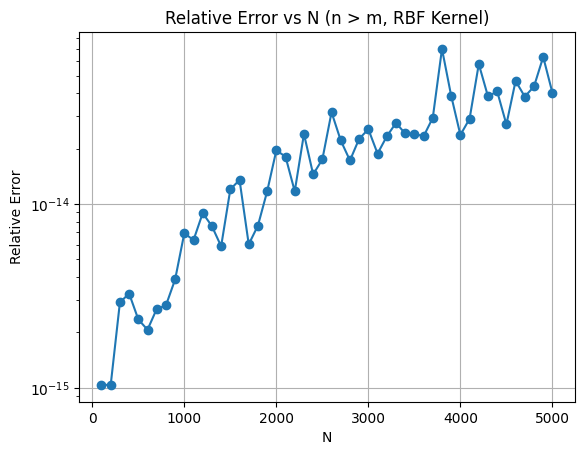

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

def rbf_kernel(X, Y, gamma):
    X_norm = np.sum(X ** 2, axis=1).reshape(-1, 1)
    Y_norm = np.sum(Y ** 2, axis=1).reshape(1, -1)
    sq_dists = X_norm + Y_norm - 2 * X @ Y.T
    return np.exp(-gamma * sq_dists)

Ns = range(100, 5001, 100)
relative_errors = []
np.random.seed(0)

gamma = 0.5
d = 10  # Dimension of data points

for N in Ns:
    n=N 
    m = n//10 # Ensure n > m
    X = np.random.randn(n, d)
    Z = np.random.randn(m, d)
    y = np.random.randn(n, 1)

    Lambda_diag = np.full(n, 1e-3)
    Lambda_inv_diag = 1 / Lambda_diag
    Lambda_inv_sqrt_diag = 1 / np.sqrt(Lambda_diag)

    K_xz = rbf_kernel(X, Z, gamma)
    K_zx = K_xz.T
    K_zz = rbf_kernel(Z, Z, gamma) + 1e-6 * np.eye(m)

    U_zz = cholesky(K_zz, lower=False)

    A_top = Lambda_inv_sqrt_diag[:, None] * K_xz
    A = np.vstack((A_top, U_zz))
    rhs = K_zx @ (Lambda_inv_diag[:, None] * y)

    Q, R = np.linalg.qr(A)
    b = np.linalg.solve(R.T, rhs)
    alpha_qr = np.linalg.solve(R, b)
    alpha_direct = np.linalg.solve(A.T @ A, rhs)
    relative_error = np.linalg.norm(alpha_qr - alpha_direct) / np.linalg.norm(alpha_direct)
    relative_errors.append(relative_error)
    print(f"N = {N}, n = {n}, m = {m}, Relative Error: {relative_error:.2e}")

plt.plot(Ns, relative_errors, marker='o')
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.yscale("log")
plt.title('Relative Error vs N (n > m, RBF Kernel)')
plt.grid(True)
plt.show()
